# Import Packages

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
# import dataloader from torch
#import dataset
# import toTesor
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import PIL
import cv2
from model import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# print all devices
torch.cuda.device_count()
# print current device
# device

1

# Save Data Folders In Variable

In [4]:
data_dir = os.path.join(os.getcwd(), 'data')
processd_dir = os.path.join(data_dir, 'processed')
high_res_dir = os.path.join(processd_dir, 'high_res')
avg_pool_dir = os.path.join(processd_dir, 'avg_pool/train')
max_pool_dir = os.path.join(processd_dir, 'max_pool/train')
nn_interp_dir = os.path.join(processd_dir, 'NN_interpolation/train')

In [5]:
assert len(os.listdir(high_res_dir)) == len(os.listdir(avg_pool_dir)) == len(os.listdir(max_pool_dir)) == len(os.listdir(nn_interp_dir))
print(len(os.listdir(high_res_dir)))

AssertionError: 

# Preprocessing
## Split To Train, Test, and Validation Sets

TODO: add shuffling to the trainning, testing and validation sets

In [5]:
def split_train_test_val(data_dir, test_size=0.1, val_size=0.1):
    files = os.listdir(data_dir)
    files = np.array(files)
    test_split = int(len(files)*test_size)
    val_split = int(len(files)*val_size)
    test_files = files[:test_split]
    val_files = files[test_split:test_split+val_split]
    train_files = files[test_split+val_split:]
    return train_files, val_files, test_files

high_res_train, high_res_val, high_res_test = split_train_test_val(high_res_dir, test_size=0.2, val_size=0.2)
avg_pool_train, avg_pool_val, avg_pool_test = split_train_test_val(avg_pool_dir, test_size=0.2, val_size=0.2)
max_pool_train, max_pool_val, max_pool_test = split_train_test_val(max_pool_dir, test_size=0.2, val_size=0.2)
nn_interp_train, nn_interp_val, nn_interp_test = split_train_test_val(nn_interp_dir, test_size=0.2, val_size=0.2)

In [6]:
assert len(high_res_train) == len(avg_pool_train) == len(max_pool_train) == len(nn_interp_train)
assert len(high_res_val) == len(avg_pool_val) == len(max_pool_val) == len(nn_interp_val)
assert len(high_res_test) == len(avg_pool_test) == len(max_pool_test) == len(nn_interp_test)
print(len(high_res_train), len(high_res_val), len(high_res_test))

2124 707 707


In [7]:
def visualize_images(data_dir1, files1, data_dir2, files2, data_dir3, files3, data_dir4, files4, num_images=5):
    fig, axs = plt.subplots(num_images, 4, figsize=(15, 15))
    for i in range(num_images):
        # todo add labels to the images
        axs[i, 0].imshow(PIL.Image.open(os.path.join(data_dir1, files1[i])))
        axs[i, 1].imshow(PIL.Image.open(os.path.join(data_dir2, files2[i])))
        axs[i, 2].imshow(PIL.Image.open(os.path.join(data_dir3, files3[i])))
        axs[i, 3].imshow(PIL.Image.open(os.path.join(data_dir4, files4[i])))

    plt.show()

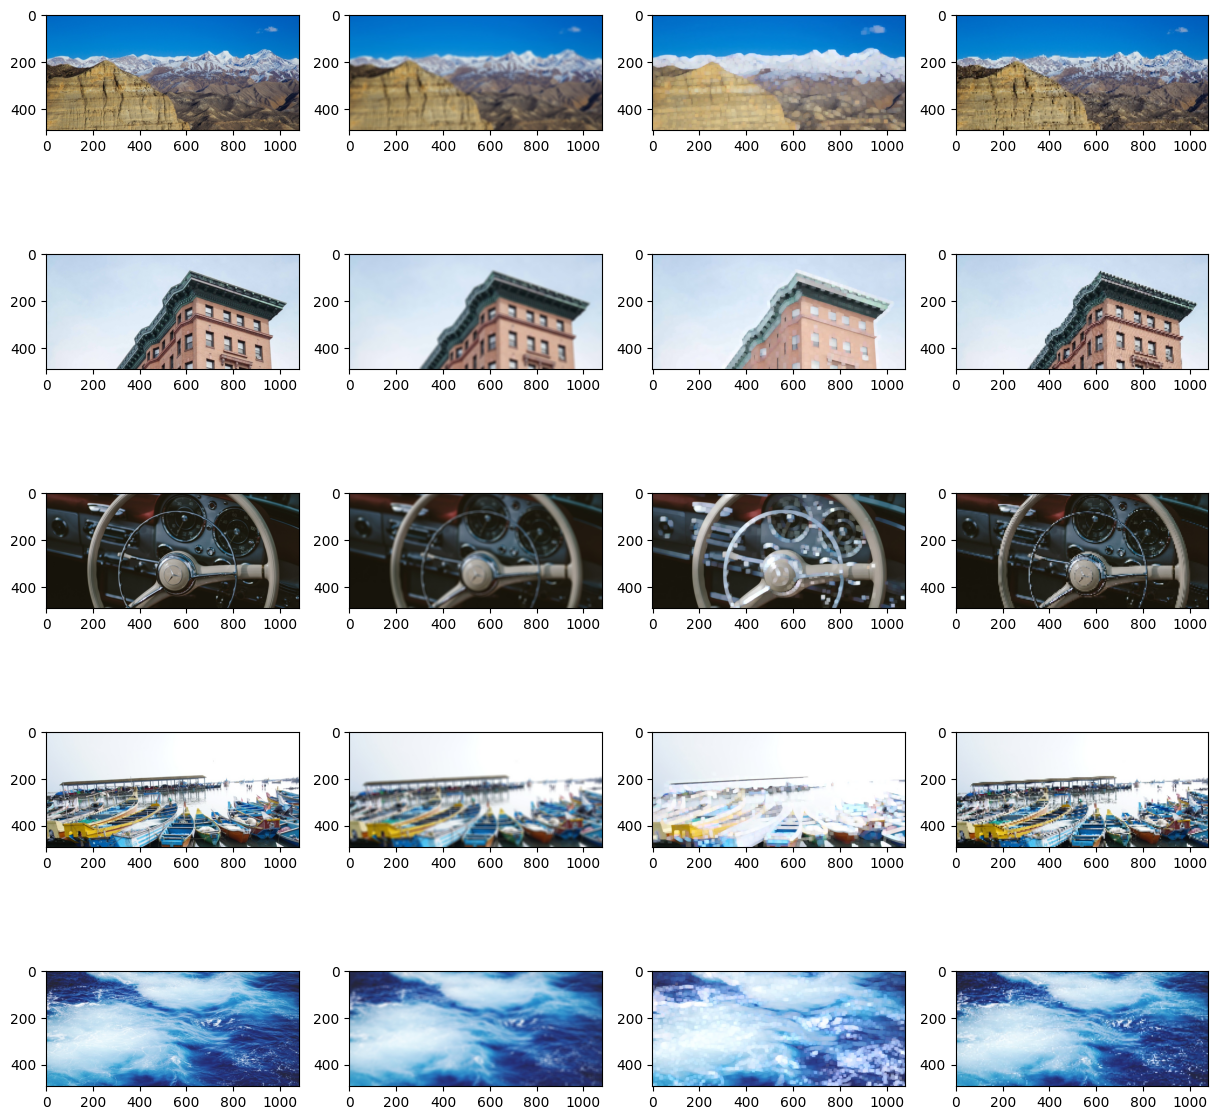

In [8]:
visualize_images(high_res_dir, high_res_train, avg_pool_dir, avg_pool_train, max_pool_dir, max_pool_train, nn_interp_dir, nn_interp_train)

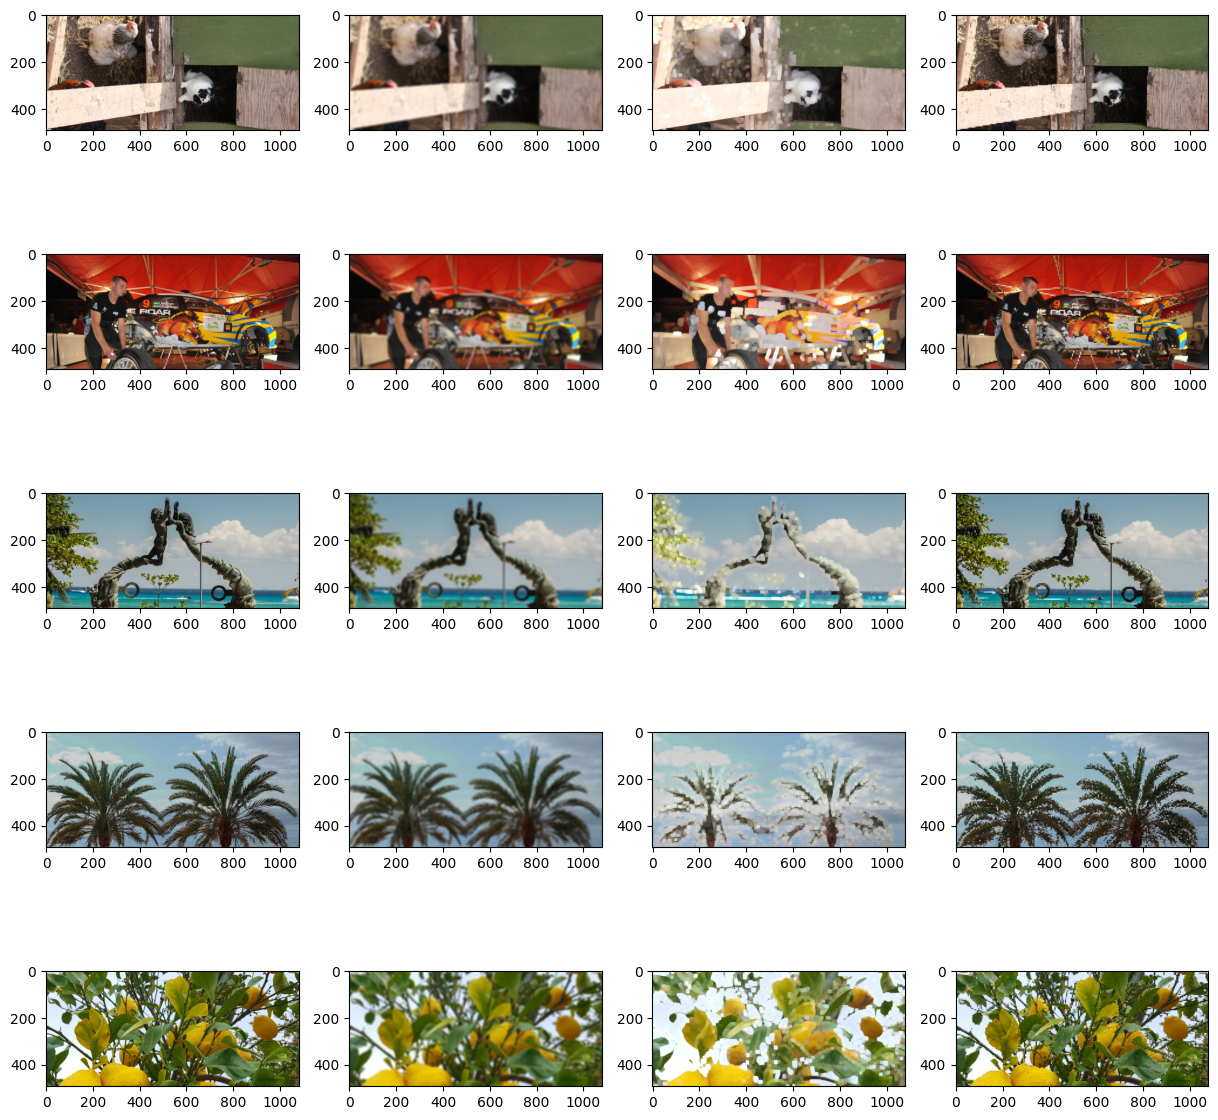

In [9]:
visualize_images(high_res_dir, high_res_val, avg_pool_dir, avg_pool_val, max_pool_dir, max_pool_val, nn_interp_dir, nn_interp_val)

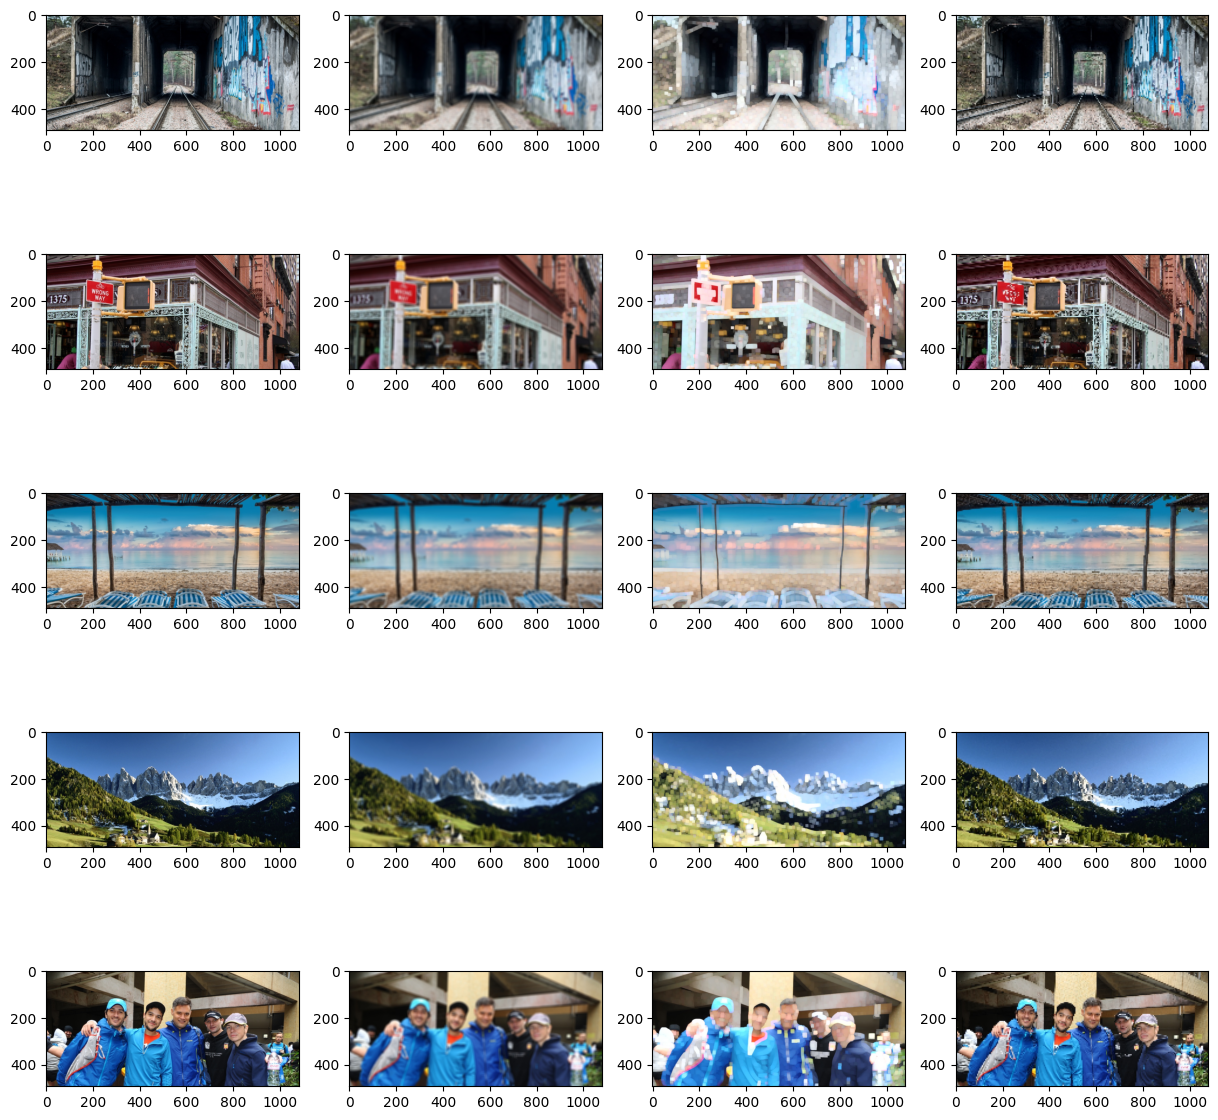

In [10]:
visualize_images(high_res_dir, high_res_test, avg_pool_dir, avg_pool_test, max_pool_dir, max_pool_test, nn_interp_dir, nn_interp_test)

In [11]:
class ImageDatasets(Dataset):
    """
    Custom Dataset class to load the
    create label and image pairs    
    """

    def __init__(self, low_dir, high_dir, low_files, high_files, transform=None, target_transform=None):
        self.low_dir = low_dir
        self.high_dir = high_dir
        self.low_files = low_files
        self.high_files = high_files
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.low_files)
    
    def __getitem__(self, idx):
        low_img = read_image(os.path.join(self.low_dir, self.low_files[idx]))
        high_img = read_image(os.path.join(self.high_dir, self.high_files[idx]))
        if self.transform:
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)
        if self.target_transform:
            high_img = self.target_transform(high_img)
        return low_img, high_img

In [36]:
train_dataset = ImageDatasets(low_dir=avg_pool_dir, high_dir=high_res_dir, low_files=avg_pool_train, high_files=high_res_train, 
transform=transforms.Resize((228, 288)))

In [37]:
train_features, train_labels = next(iter(train_dataset))
print(train_features.shape, train_labels.shape)

torch.Size([3, 228, 288]) torch.Size([3, 228, 288])


In [34]:
def visualize_images2(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 15))
    for i in range(len(images)):
        # make images from float tensor to numpy array
        axs[i].imshow(images[i].numpy().transpose(1, 2, 0))
        # reshape images to 3 channels
        # axs[i].imshow(images[i].permute(1, 2, 0))

    plt.show()

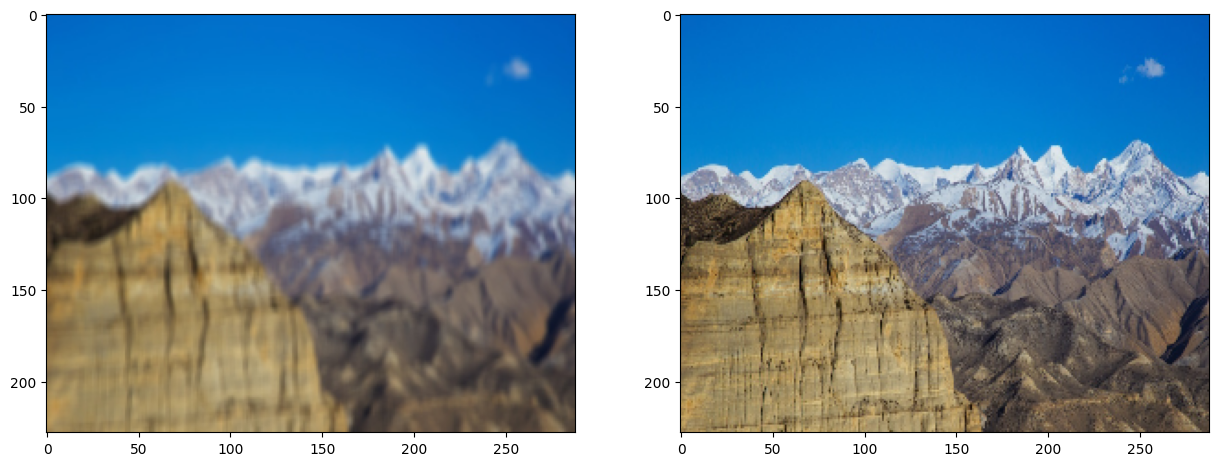

In [38]:
visualize_images2([train_features, train_labels])

In [16]:
# make dataloaders
avg_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [17]:
# create validation dataset
val_dataset = ImageDatasets(low_dir=avg_pool_dir, high_dir=high_res_dir, low_files=avg_pool_val, high_files=high_res_val, transform=None)

# make dataloaders
avg_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# create test dataset
test_dataset = ImageDatasets(low_dir=avg_pool_dir, high_dir=high_res_dir, low_files=avg_pool_test, high_files=high_res_test, transform=None)

# make dataloaders
avg_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Models

## Models for Average Pooling 

In [30]:
# create a model
class SuperResolutionModelAvg(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(SuperResolutionModelAvg, self).__init__()
        # define the layers input is 3x492x1080 output is 3x492x1080
        # define max pooling layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # define average pooling layer
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        # define the upsampling layers
        # self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        # define the output layer 3x492x1080
        self.conv_out = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        #convert to double
        # self.output =nn.Linear(248, 84)
        self.linear1 = nn.Linear(248, 84)
        self.linear2 = nn.Linear(84, 28)
        self.float()
    
    def forward(self, x):
        # turn x to float
        x = x.float()
        # define the forward pass
        x = F.relu(self.conv1(x))
        x = self.avg_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # x = self.upsample(x)
        x = self.conv_out(x)
        print(x.shape)
        # x = self.output(x)
        return x

In [31]:
s = SuperResolutionModelAvg()
# random tensor
x = torch.randn(1, 3, 492, 1080)
s(x)

torch.Size([1, 3, 123, 270])


tensor([[[[-0.0996, -0.1399, -0.0843,  ..., -0.0394, -0.0409,  0.0089],
          [-0.1306, -0.1243, -0.1191,  ..., -0.1003, -0.0339, -0.0117],
          [-0.2122, -0.1366, -0.0810,  ..., -0.1059, -0.0727, -0.0052],
          ...,
          [-0.1376, -0.1707, -0.0556,  ..., -0.0710, -0.0595,  0.0222],
          [-0.1352, -0.1181, -0.0475,  ..., -0.1169, -0.0710, -0.0266],
          [-0.1439, -0.0566, -0.0143,  ..., -0.0203, -0.0156, -0.0302]],

         [[-0.0542, -0.0751, -0.0385,  ..., -0.0546, -0.0589, -0.1350],
          [-0.0136, -0.0424, -0.1870,  ..., -0.0980, -0.0241, -0.1613],
          [ 0.0100, -0.0577, -0.0646,  ..., -0.1166, -0.0792, -0.1960],
          ...,
          [-0.0075, -0.0855, -0.0929,  ..., -0.0391, -0.1074, -0.1337],
          [ 0.0517, -0.0166, -0.1119,  ..., -0.1044, -0.0781, -0.1326],
          [ 0.0031, -0.1051, -0.0428,  ..., -0.1694, -0.1166, -0.1947]],

         [[-0.0116,  0.0304,  0.0143,  ...,  0.0228,  0.0061, -0.0128],
          [ 0.0157,  0.0687,  

In [86]:
# train on a model
train_on_gpu = torch.cuda.is_available()
batch_index = 0

def train(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    # define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, num_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_index + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.float(), target.float())
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_index + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in val_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_index + 1)) * (loss.data - valid_loss))
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

In [7]:
# train the model
model = SuperResolutionModelAvg()
if train_on_gpu:
    model.cuda()
train(model, avg_train_loader, avg_val_loader, num_epochs=10, learning_rate=0.001)

NameError: name 'SuperResolutionModelAvg' is not defined